In [1]:
import os
import csv
import json
import math
import pickle
import time
import random
import datetime
import numpy as np
import pandas as pd
import community
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from scipy.interpolate import griddata

from util import *

In [2]:
Data_Root = '/data/haopeng/Diffusion/RealNet/'
net_name = 'twitter'

In [16]:
G = nx.read_edgelist(Data_Root+'networks/twitter_combined.txt', delimiter=' ', create_using=nx.DiGraph(), nodetype=str)

In [11]:
len(G.nodes())

81306

In [12]:
len(G.edges())

1768149

In [17]:
# G = G.to_undirected(reciprocal=True)
G = G.to_undirected(reciprocal=False)

In [14]:
len(G.nodes())

81306

In [15]:
len(G.edges())

425853

In [7]:
len(G.nodes())

81306

In [8]:
len(G.edges())

1342310

In [18]:
nx.is_connected(G)

True

In [19]:
# largest cc
Gcc = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(Gcc).copy()

In [20]:
len(Gcc.nodes())

81306

In [21]:
len(Gcc.edges())

1342310

In [22]:
part = community.best_partition(Gcc, randomize=False)

In [23]:
len(part)

81306

In [24]:
community.modularity(part, Gcc)

0.8064833076267355

Calculate normalized modularity (also called assortative coeff)

In [28]:
attribute_assortativity_coefficient(Gcc, part)

0.8581873118740464

In [25]:
with open(Data_Root+'networks/partition_%s.pickle'%net_name, 'wb') as file:
    pickle.dump(part, file)

In [26]:
cid_nodes = defaultdict(set)

for node, cid in part.items():
    cid_nodes[cid].add(node)
cid_nodes = dict(cid_nodes)

In [27]:
print('There are %d communities'%len(cid_nodes))
print('The smallest community has %d nodes'%min([len(li) for cid, li in cid_nodes.items()]))
print('The largest community has %d nodes'%max([len(li) for cid, li in cid_nodes.items()]))

There are 70 communities
The smallest community has 27 nodes
The largest community has 9567 nodes


### Simulation

In [ ]:
num_nodes = len(Gcc.nodes())
num_edges = len(Gcc.edges())
num_community = len(cid_nodes)
num_switches = num_edges//2

In [ ]:
Gcc_cp, cid_cid_edges, valid_same_comm_pairs, valid_cross_comm_pairs = prepare_data(Gcc, part)

In [ ]:
print('Only %d pairs of communities (including same pair) have edges running between'%len(cid_cid_edges))
print('We can sample cross-community edges from %d pairs of communities.'%len(valid_cross_comm_pairs))
print('We can sample same-community edges from %d communities.'%len(valid_same_comm_pairs))

In [3]:
rho = 0.1
num_seeds = int(rho*num_nodes)
thsh = 0.3
num_runs = 100
f = 0.01
ps = np.arange(0, 1.02, 0.02)

In [31]:
p_to_Q = {}

for p in [0.2, 0.4, 0.6, 0.8]:
    Gcc_cp, cid_cid_edges, valid_same_comm_pairs, valid_cross_comm_pairs = prepare_data(Gcc, part)
    swap_edges(Gcc_cp, cid_cid_edges, valid_same_comm_pairs, valid_cross_comm_pairs, num_switches, p)
    Q_norm = attribute_assortativity_coefficient(Gcc_cp, part)
    p_to_Q[p] = Q_norm

In [32]:
p_to_Q

{0.2: 0.8987552789940185,
 0.4: 0.8142596885877709,
 0.6: 0.5632462838718277,
 0.8: 0.19641590717090365}

### Phase diagram

First run the script in the folder `twitter_hpc` on hpc.
- run this command: `sbatch twitter_hpc.slurm`

In [ ]:
# results = defaultdict(dict)

# for i in range(51):
#     p = ps[i]
#     with open(Data_Root+'per_step_data/phase_simu_%s_thsh_%s_f_%s_%s.pickle'%(net_name, thsh, f, i), 'rb') as file:
#         tem = pickle.load(file)
#         for rho, li in tem.items():
#             results[rho][p] = li

In [ ]:
# with open(Data_Root+'per_step_data/phase_simu_%s_thsh_%s_f_%s.pickle'%(net_name, thsh, f), 'wb') as file:
#     pickle.dump(dict(results), file)

In [8]:
with open(Data_Root+'per_step_data/phase_simu_%s_thsh_%s_f_%s.pickle'%(net_name, thsh, f), 'rb') as file:
    results = pickle.load(file)

In [5]:
rhos = np.arange(0, 0.51, 0.01)

In [11]:
sweeping_results = defaultdict(dict)

for rho in rhos:
    num_seeds = int(rho*num_nodes)
    for u in ps:
        tem_results = []
        for size, step, activation_per_step in results[rho][u]:
            tem_results.append((size, step))
        sizes = [size/num_nodes for (size, step) in tem_results]
        rates = [(size-num_seeds)/(step*num_nodes) if step > 0 else 0 for (size, step) in tem_results]
        sweeping_results[rho][u] = (sizes, rates)

In [12]:
x_range = np.arange(0, 1.001, 0.001)
y_range = np.arange(0, 0.501, 0.001)
X, Y = np.meshgrid(x_range, y_range)

In [13]:
points = []
values_size = []
values_rate = []
lower_boundary = []
upper_boundary = []
max_rate = []
            
for rho in rhos:
    lower_u, upper_u = 'none', 'none'
    # u refers p here.
    for u in ps:
        points.append([u, rho])
        avg_size = np.mean(sweeping_results[rho][u][0])
        values_size.append(avg_size)
        avg_rate = np.mean(sweeping_results[rho][u][1])
        values_rate.append(avg_rate)
        
        if avg_size >= 0.99:
            if lower_u == 'none':
                lower_u = u
            upper_u = u
    if lower_u < upper_u:
        lower_boundary.append([lower_u, rho])
        upper_boundary.append([upper_u, rho])
        optimal_u = 0
        min_rate = np.mean(sweeping_results[rho][lower_u][1])
        for u in ps:
            if u >= lower_u and u <= upper_u:
                avg_rate = np.mean(sweeping_results[rho][u][1])
                if avg_rate >= min_rate:
                    optimal_u = u
                    min_rate = avg_rate
        max_rate.append([optimal_u, rho])

lower_boundary = np.array(lower_boundary)
upper_boundary = np.array(upper_boundary)
max_rate = np.array(max_rate)

Z_size = griddata(points, values_size, (X, Y), method = 'cubic')
Z_rate = griddata(points, values_rate, (X, Y), method = 'cubic')

In [14]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.0f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

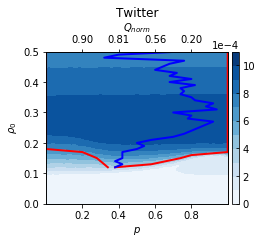

In [43]:
fig, ax = plt.subplots(figsize = (3.5, 2.8))
levels = np.linspace(0.0, 11e-4, 12)
ct = ax.contourf(X, Y, Z_rate, cmap = 'Blues', levels=levels)#, extend='min'
cb = fig.colorbar(ct, ax=ax, fraction=0.05, pad=0.02, format=OOMFormatter(-4, mathText=False))
cb.ax.tick_params(axis='y', direction='in')

ax.plot(lower_boundary[:, 0], lower_boundary[:, 1], linewidth = 2, color='r')
ax.plot(upper_boundary[:, 0], upper_boundary[:, 1], linewidth = 2, color='r')
ax.plot(max_rate[:, 0], max_rate[:, 1], linewidth = 2, color='b')
# ax.axhline(y=0.10, linewidth=1, linestyle='--', color='k')
# ax.text(0.05, 0.95, 'a', fontsize=12, ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\rho_0$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)
xticks = [0.2, 0.4, 0.6, 0.8]
ax.set_xticks(xticks)
ax.set_title('Twitter', pad = 35)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels(["%.2f"%p_to_Q[p] for p in xticks])
ax2.set_xlabel(r"$Q_{norm}$")

plt.show()
fig.savefig('%s_phase.pdf'%net_name, bbox_inches='tight', pad_inches=0.02)